## MIE424 (2023 Winter) Lab 5

Presented by Jerry Sun

  *  part 1)       Using JAX to calculate gradients for Gradient Descent
  *  part 2)       Visualizing Gradient Descent
  *  part 3)       Visualizing Project Gradient Descent
  *  part 4)       Gradient descent for non-convex functions

# Import and Installations

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline
import scipy.optimize as opt
import scipy.linalg as la
from tqdm import tqdm

## 1. Using JAX to calculate Gradients

This part of the lab will explain how to automatically calculate gradients that can then be used in many optimiazation algorithms, such as gradient descent.

  *  The hope is to give you a base to be able to implement algorithms manually.
  *  Visualizing these concepts makes life much easier.
  *  Get into the habit of trying things out! Machine learning is wonderful because it is so successful.

You can differentiate a function with `grad`:

`grad` takes a function and returns a function. If you have a Python function `f` that evaluates the mathematical function $f$, then `grad(f)` is a Python function that evaluates the mathematical function $\nabla f$. That means `grad(f)(x)` represents the value $\nabla f(x)$.


In [4]:
grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))

0.070650816



Since `grad` operates on functions, you can apply it to its own output to differentiate as many times as you like:

In [5]:
print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

-0.13621868
0.25265405


Let's know use JAX for GD for some dataset

In [6]:
# Step 1: Create data for gradient descent
key = random.PRNGKey(1)

data_points, data_dimension = 100, 2

# Generate X and w, then set y = Xw + ϵ
X = random.normal(key, (data_points, data_dimension))

true_w = random.normal(key, (data_dimension,))
y = X @ true_w + 0.1 * random.normal(key, (data_points,))

In [7]:
# Step 2: Compute the linear algebra solution
'''
    - Given the data matrix X and the vector of labels y, compute the solution to ordinary least squares as shown in class
'''
w_linalg = np.linalg.inv(X.T @ X) @ X.T @ y
print(w_linalg)

[-0.15762302  0.08178266]


Recall Gradient Descent algo from lecture

  *  Start with initial guess $w^0$
  *  While ||$\nabla f(w^t)$|| > ϵ
      *  $w^{t+1} = w^{t} - \alpha^{t} * ||\nabla f(w^t)$||

$\alpha^{t} > 0 $ : a step size or learning rate

$ \epsilon >= 0 $ : Convergence threshold (small constant)


In [8]:
# Step 3: Use basic gradient descent with 100 iterations and step size of 0.1 to find w_grad
def make_squared_error(X, y):
    # calculate squared error
    def squared_error(w):
        return ((X @ w - y) ** 2).mean()
    return squared_error

In [9]:
alpha = 0.1
iterations = 100
## init param gd
w_gd = np.zeros(data_dimension)

In [10]:
# Now use jax grad
grad_loss = grad(make_squared_error(X, y))
for i in range(iterations):
    ### INSERT CODE HERE
    w_gd = w_gd - alpha * grad_loss(w_gd)

In [11]:
print("\t w* retrieved with gradient descent: \t \t ",w_gd)
print("\t w* retrieved using algebraic solution to OLS: \t ",w_linalg)

	 w* retrieved with gradient descent: 	 	  [-0.15762305  0.08178265]
	 w* retrieved using algebraic solution to OLS: 	  [-0.15762302  0.08178266]


### Finite Difference Estimation

One way to estimate the gradient at a certain point is to take the "slope" at that point with a very small step in x.
Let's check if the grad of jax is accurate and makes sense numerically using finite differences.

$\frac{\partial f(x)}{\partial x} \approx \frac{f(x+\epsilon) - f(x-\epsilon)}{2 \epsilon}$

In [12]:
# Set a step size for finite differences calculations
eps = 1e-2
w = true_w

# random key
key, subkey = random.split(key)

# squared error with different w
squared_error = make_squared_error(X, y)

# Check W_grad with finite differences in a random direction
vec = random.normal(subkey, w.shape)
unitvec = vec / jnp.linalg.norm(vec)
delta = eps * unitvec
w_grad_numerical = (squared_error(w + delta) - squared_error(w - delta)) / (2 * eps)

print('w_grad_numerical', w_grad_numerical)
print('W_dirderiv_autodiff',  (grad(make_squared_error(X, y))(w) @ unitvec))

w_grad_numerical -0.0051701907
W_dirderiv_autodiff -0.0051702135


In [13]:
for eps in np.logspace(-8,0,9):
    delta = eps * unitvec
    w_grad_numerical = (squared_error(w + delta) - squared_error(w - delta)) / (eps * 2)
    print(f'Epsilon used: {eps}, directional derivative with FDM:  {w_grad_numerical}, difference with autodiff: {abs(w_grad_numerical-jnp.vdot(grad(make_squared_error(X, y))(w), unitvec))}')

Epsilon used: 1e-08, directional derivative with FDM:  -0.046566128730773926, difference with autodiff: 0.04139591380953789
Epsilon used: 1e-07, directional derivative with FDM:  0.0, difference with autodiff: 0.005170213524252176
Epsilon used: 1e-06, directional derivative with FDM:  -0.005122274160385132, difference with autodiff: 4.793936386704445e-05
Epsilon used: 1e-05, directional derivative with FDM:  -0.00521540641784668, difference with autodiff: 4.51928935945034e-05
Epsilon used: 0.0001, directional derivative with FDM:  -0.005173496901988983, difference with autodiff: 3.2833777368068695e-06
Epsilon used: 0.001, directional derivative with FDM:  -0.005170236807316542, difference with autodiff: 2.3283064365386963e-08
Epsilon used: 0.01, directional derivative with FDM:  -0.005170190706849098, difference with autodiff: 2.2817403078079224e-08
Epsilon used: 0.1, directional derivative with FDM:  -0.005170218646526337, difference with autodiff: 5.122274160385132e-09
Epsilon used: 

# Part 2) Visualizing Gradient Descent

Now we are going to talk about visualizing each step in the gradient descent algorithm, starting with a one dimensional, and then continuing with a two dimensional data. We will be looking at how this affects both the data space (X vs Y) and the parameter space (w0 vs w1 vs Loss).

#### Visualization for 1 dimensional data

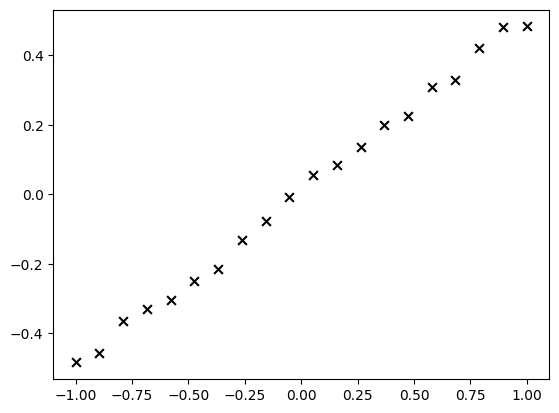

In [14]:
# First consider the 1 dimensional data case.

# Create the data we want to fit
m = 20
w_true = 0.5
x = np.linspace(-1,1,m)
y = w_true * x + 0.02 * np.random.randn(m)

# let's visualize it
plt.scatter(x, y, marker='x', s=40, color='k')
plt.show()

For the 1-D case implement the cost function for OLS and the linear hypothesis

- for the cost function use mean squared error (MSE)
- for the linear hypothesis, $b = 0$ in $y=w^\intercal x + b$

In [15]:
def cost_func(w):
    """The cost function, J(w) describing the goodness of fit."""
    ### INSERT CODE HERE
    return ((y - hypothesis(x, w)) ** 2).mean()

def hypothesis(x, w):
    """Our "hypothesis function", a straight line through the origin."""
    ### INSERT CODE HERE
    return w * x

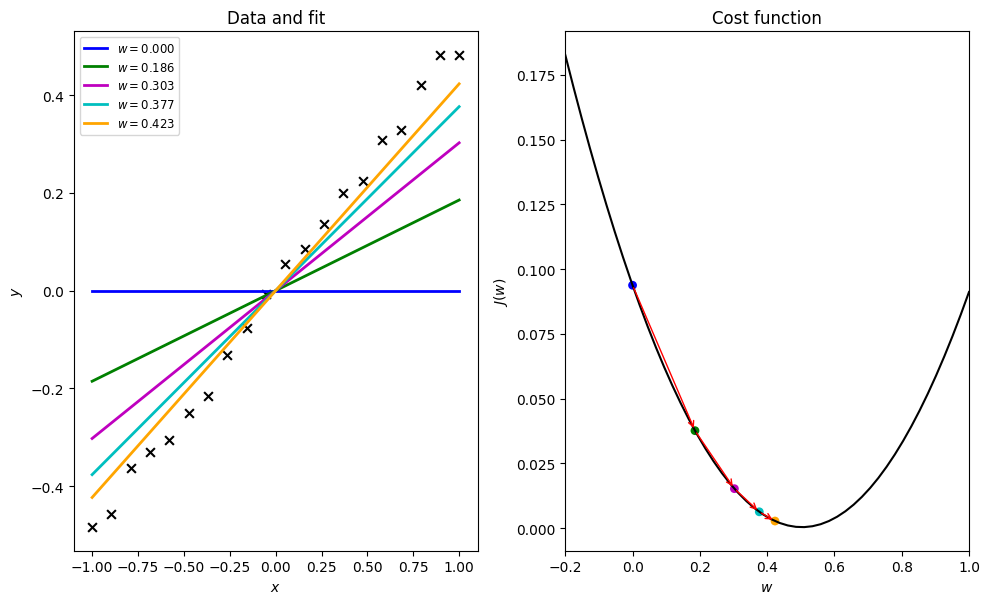

In [16]:
# The plot: LHS is the data, RHS will be the cost function.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

# First construct a grid of W parameter pairs and their corresponding
# cost function values.
w_grid = np.linspace(-0.2,1,50)
loss_grid = np.array([cost_func(w) for w in w_grid])

# The cost function as a function of its single parameter, theta1.
ax[1].plot(w_grid, loss_grid, 'k')

# Take N steps with learning rate alpha down the steepest gradient,
# starting at theta1 = 0.
N = 5
alpha = 1
w = 0
losses, ws = [cost_func(w)], [w]
for j in range(N-1):
    grad_w = ((hypothesis(x, w) - y) * x).mean()
    w -= grad_w
    ws.append(w)
    losses.append(cost_func(w))

# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, ws[0]), color=colors[0], lw=2,
           label=r'$w = {:.3f}$'.format(ws[0]))
for j in range(1,N):
    ax[1].annotate('', xy=(ws[j], losses[j]), xytext=(ws[j-1], losses[j-1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, ws[j]), color=colors[j], lw=2,
               label=r'$w = {:.3f}$'.format(ws[j]))

# Labels, titles and a legend.
ax[1].scatter(ws, losses, c=colors, s=40, lw=0)
ax[1].set_xlim(-0.2,1)
ax[1].set_xlabel(r'$w$')
ax[1].set_ylabel(r'$J(w)$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
ax[0].legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

#### Visualization for 2 dimensional data

In [17]:
# The data to fit
m = 20
w_true = 0.5
b_true = 2
x = np.linspace(-1,1,m)
y = w_true * x + b_true + 0.02 * np.random.randn(m)

In [18]:
def cost_func(b, w):
    """The cost function, J(theta0, theta1) describing the goodness of fit."""
    ### INSERT CODE HERE
    return ((y - hypothesis(x, w, b)) ** 2).mean()

def hypothesis(x, b, w):
    """Our "hypothesis function", a straight line."""
    ### INSERT CODE HERE
    return w * x + b

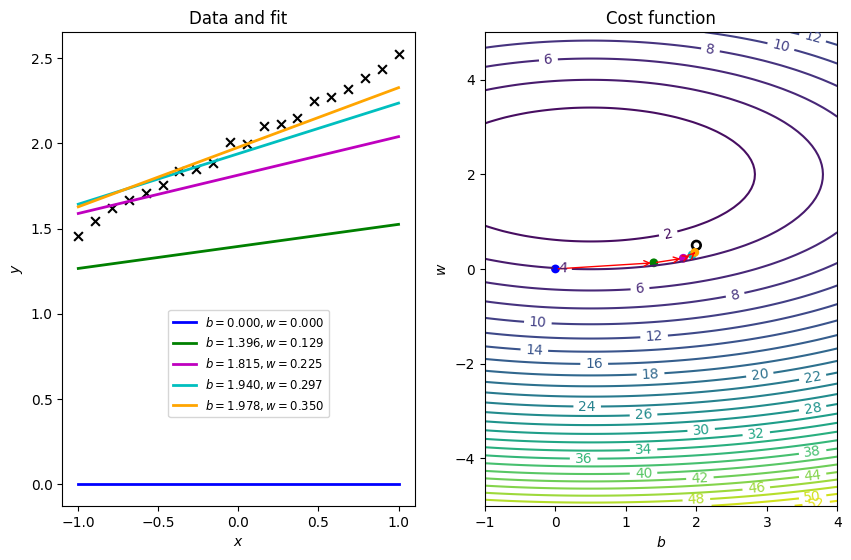

In [19]:
# The plot: LHS is the data, RHS will be the cost function.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

# First construct a grid of (theta0, theta1) parameter pairs and their
# corresponding cost function values.
b_grid = np.linspace(-1,4,101)
w_grid = np.linspace(-5,5,101)
loss_grid = np.array([[cost_func(b, w) for b in b_grid] for w in w_grid])

# A labeled contour plot for the RHS cost function
X, Y = np.meshgrid(b_grid, w_grid)
contours = ax[1].contour(X, Y, loss_grid, 30)
ax[1].clabel(contours)
# The target parameter values indicated on the cost function contour plot
ax[1].scatter([b_true]*2,[w_true]*2,s=[50,10], color=['k','w'])


# Take N steps with learning rate alpha down the steepest gradient,
# starting at (theta0, theta1) = (0, 0).
N = 5
alpha = 0.7
b, w = 0, 0
params, losses = [(b, w)], [cost_func(b, w)]
for j in range(N-1):
    grad_b = (hypothesis(x, b, w) - y).mean()
    grad_w = ((hypothesis(x, b, w) - y) * x ).mean()
    b = b - alpha * grad_b
    w = w - alpha * grad_w
    params.append((b, w))
    losses.append(cost_func(b, w))

# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, *params[0]), color=colors[0], lw=2,
           label=r'$b = {:.3f}, w = {:.3f}$'.format(*params[0]))
for j in range(1,N):
    ax[1].annotate('', xy=params[j], xytext=params[j-1],
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, *params[j]), color=colors[j], lw=2,
           label=r'$b = {:.3f}, w = {:.3f}$'.format(*params[j]))
ax[1].scatter(*zip(*params), c=colors, s=40, lw=0)

# Labels, titles and a legend.
ax[1].set_xlabel(r'$b$')
ax[1].set_ylabel(r'$w$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
axbox = ax[0].get_position()
# Position the legend by hand so that it doesn't cover up any of the lines.
ax[0].legend(loc=(axbox.x0+0.5*axbox.width, axbox.y0+0.1*axbox.height),
             fontsize='small')

plt.show()

# Part 3)       Visualizing Project Gradient Descent

In [20]:
def generate_data(num_samples, num_features, num_nonneg, nonneg_value, noise):
    # Making sure that a projection is acctually needed for this dataset
    w_star = np.random.randn(num_features) - 5
    w_star[:num_nonneg] = nonneg_value
    X = 10 * np.random.randn(num_samples, num_features)
    Y = X @ w_star + noise * np.random.randn(num_samples)
    return X, Y, w_star

In [21]:
def nonneg_project(w, S):
    # u is the orginal vector and S is the set to be non-nenagtive
    v = np.copy(w)
    v[S] = np.maximum(0, v[S])
    return v

def loss(w):
    # MSE loss
    return ((Y.reshape(-1, 1) - X @ w) ** 2).sum(axis=0) / 2

def nonneg_OLS(X, Y, S, max_iter):
    # avoid duplicated calculation
    XTX  = X.T @ X
    XTY  = X.T @ Y
    # step size
    alpha = 1 / np.max(np.linalg.eigvals(XTX))
    # init parametsers
    ws = np.zeros((max_iter+1, X.shape[1]))
    w = ws[0]
    # gradient descent
    for i in range(max_iter):
        w = w - alpha * (XTX @ w - XTY)
        w = nonneg_project(w, S)
        ws[i+1,:] = w
    return w, ws

def OLS(X, Y, max_iter):
    # avoid duplicated calculation
    XTX  = X.T @ X
    XTY  = X.T @ Y
    # step size
    alpha = 1 / np.max(np.linalg.eigvals(XTX))
    # init parametsers
    ws = np.zeros((max_iter+1, X.shape[1]))
    w = ws[0]
    # gradient descent
    for i in range(max_iter):
        w = w - alpha * (XTX @ w - XTY)
        ws[i+1,:] = w
    return w, ws

In [22]:
# use the np.random.seed to fix the generated data
np.random.seed(424)
# generate a dataset of 100 samples with 2 features each
X, Y, w_star = generate_data(100,2,1,0.05,100)

In [23]:
w_star

array([ 0.05      , -3.66342581])

In [24]:
w_hat, ws = nonneg_OLS(X, Y, np.arange(1), 10)

Text(0.5, 1.0, 'Vanilla gradient descent')

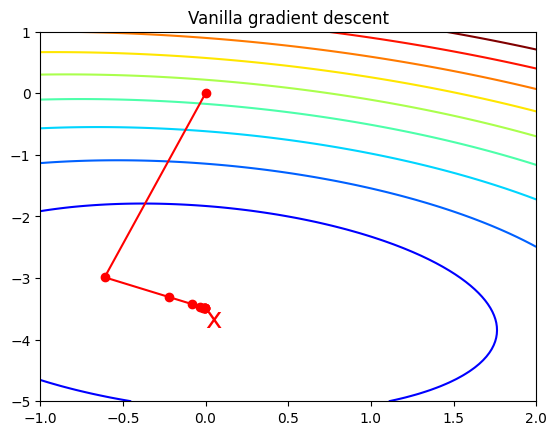

In [25]:
w_hat, ws = OLS(X,Y,10)
x = np.linspace(-1, 2, 100)
y = np.linspace(-5, 1, 100)
X_plot, Y_plot = np.meshgrid(x, y)
Z = loss(np.vstack([X_plot.ravel(), Y_plot.ravel()])).reshape((100,100))
Zmin = np.min(Z)
Zmax = np.max(Z)
# plot the contour's of the objective value for specific beta
plt.contour(X_plot, Y_plot, Z, np.arange(10)/10*(Zmax-Zmin)+Zmin, cmap='jet')
# plot the true optimum
plt.text(w_star[0], w_star[1], 'x', va='center', ha='center', color='red', fontsize=20)
# plot w for every iteration
plt.plot(ws[:, 0], ws[:, 1], 'o-', c='red')
plt.title('Vanilla gradient descent')

Text(0.5, 1.0, 'Non Negative gradient descent')

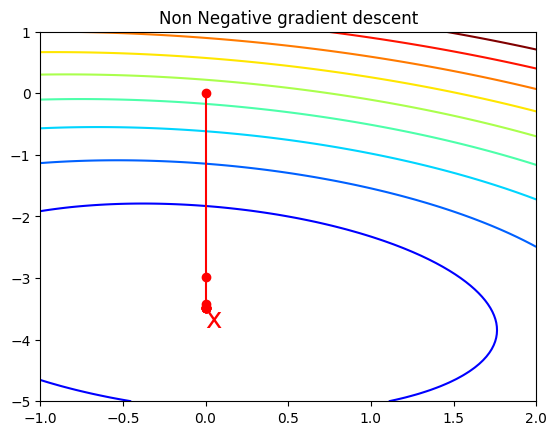

In [26]:
w_hat, ws = nonneg_OLS(X,Y,np.arange(1),10)
x = np.linspace(-1, 2, 100)
y = np.linspace(-5, 1, 100)
X_plot, Y_plot = np.meshgrid(x, y)
Z = loss(np.vstack([X_plot.ravel(), Y_plot.ravel()])).reshape((100,100))
Zmin = np.min(Z)
Zmax = np.max(Z)
# plot the contour's of the objective value for specific beta
plt.contour(X_plot, Y_plot, Z, np.arange(10)/10*(Zmax-Zmin)+Zmin, cmap='jet')
# plot the true optimum
plt.text(w_star[0], w_star[1], 'x', va='center', ha='center', color='red', fontsize=20)
# plot w for every iteration
plt.plot(ws[:, 0], ws[:, 1], 'o-', c='red')
plt.title('Non Negative gradient descent')

# Part 4) Gradient Descent with Non-convex Functions

In this section, we apply gradient descent method trying to minimize the following function:

$f(x)=100(x_2-x_1^2)^2+(1-x_1)^2$

This function is a special case of rosenbrock (banana) function.

In [27]:
def rosen(x):
    """
    The Rosenbrock function.
    The function computed is::
        sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

    Parameters
    x : array of points at which the Rosenbrock function is to be computed.

    Returns
    r : float. The value of the Rosenbrock function.
    """
    return (100 * (x[1:] - x[:-1] ** 2)**2 + (1 - x[:-1]) ** 2).sum(axis=0)

In [28]:
def rosen_grad(x):
    """
    The derivative (i.e. gradient) of the Rosenbrock function.

    Parameters
    x : array of points at which the derivative is to be computed.

    Returns
    rosen_grad : (N,) ndarray
        The gradient of the Rosenbrock function at `x`.
    """
    grad_x1 = - 400 * x[0] *(x[1] - x[0] ** 2) + 2 * (x[0] - 1)
    grad_x2 = 200 * (x[1] - x[0] ** 2)
    return np.array([grad_x1, grad_x2])

Check if your implementation is correct:

In [29]:
# the generated data
for x in random.uniform(key, shape=(10,2), minval=-2, maxval=2):
    print(np.isclose(grad(rosen)(x), rosen_grad(x)))

[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]
[ True  True]


**Question:**

What's the global minimum for the function $f(x)=100(x_2-x_1^2)^2+(1-x_1)^2$?

In [30]:
x_star = jnp.array([1,1])

In [32]:
rosen(x_star)

Array(0, dtype=int32)

In [33]:
rosen_grad(x_star)

array([0, 0], dtype=int32)

Visualize $f(x)$ by contour.

Text(0, 0.5, 'x_{2}')

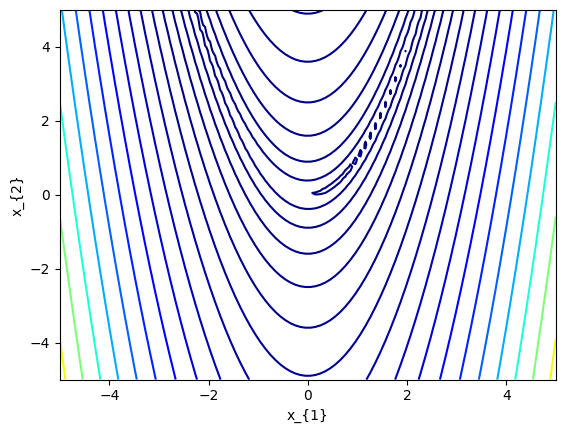

In [34]:
x = jnp.linspace(-5, 5, 100)
y = jnp.linspace(-5, 5, 100)
X, Y = jnp.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(20)**4, cmap='jet')
plt.xlabel('x_{1}')
plt.ylabel('x_{2}')

Zooming in to the global minimum `x_star`

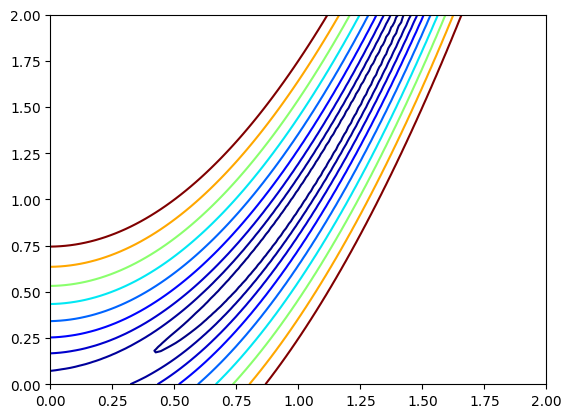

In [35]:
x = jnp.linspace(0, 2, 100)
y = jnp.linspace(0, 2, 100)
X, Y = jnp.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')

**Exercise:**

Complete the update rule in the gradient descent funciton `gd()`.

In [36]:
def gd(x, grad, alpha, max_iter=10):
    # starting intialization
    # gradient of function
    # step size or learning rate
    # max number of iterations
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0,:] = x
    for i in range(max_iter):
        ### INSERT CODE HERE

    return xs

IndentationError: expected an indented block after 'for' statement on line 8 (932430945.py, line 11)

In [37]:
alpha = 0.0002
x0 = np.array([4,-4])
xs = gd(x0, rosen_grad, alpha, max_iter=100)

NameError: name 'gd' is not defined

Let's visualize the iterates of the gradient descent.

NameError: name 'xs' is not defined

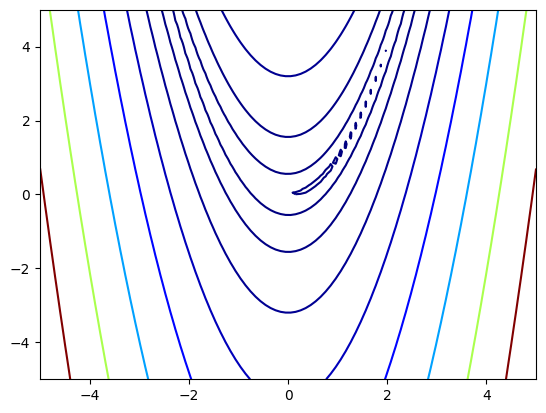

In [38]:
x = jnp.linspace(-5, 5, 100)
y = jnp.linspace(-5, 5, 100)
X, Y = jnp.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Vanilla gradient descent')

In [39]:
x0=xs[-1,:]
x0

NameError: name 'xs' is not defined

In [40]:
alpha = 0.0002
x0 = np.array([4,-4])
for i in range(10):
    print(f'Iterations: {1000+i*1000}')
    plt.figure(i)
    xs = gd(x0, rosen_grad, alpha, max_iter=1000*(1+i))
    x = jnp.linspace(-5, 5, 100)
    y = jnp.linspace(-5, 5, 100)
    X, Y = jnp.meshgrid(x, y)
    Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
    plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
    plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
    plt.title('Vanilla gradient descent')

Iterations: 1000


NameError: name 'gd' is not defined

<Figure size 640x480 with 0 Axes>

Now let's consider increasing the stepsize:


In [41]:
alpha = 0.0003
x0 = np.array([4,-4])
xs = gd(x0, rosen_grad, alpha, max_iter=10)
xs

NameError: name 'gd' is not defined

### Wow, what happend?

gradient descent is taking successive steps in the direction of the minimum. If the step size is too large, it can (plausibly) "jump over" the minima we are trying to reach, ie. we overshoot. This can lead to osculations around the minimum or in some cases to outright divergence.

What about adapatively increase the stepsize? For example, $\alpha=\alpha_0 \sqrt{k}$ for the $k$th iterate.

In [42]:
def adaptive_gd(x, grad, alpha, max_iter=10):
    xs = np.zeros((1 + max_iter, x.shape[0]))
    xs[0,:] = x
    for i in range(max_iter):
        x = x - alpha * np.sqrt(i) * grad(x)
        xs[i+1,:] = x
    return xs

[0.83120453 0.68990336]


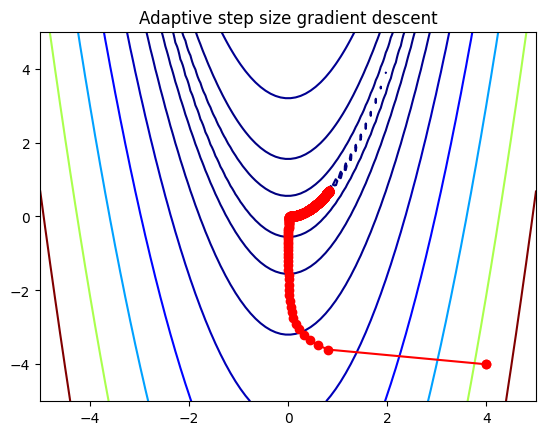

In [43]:
alpha = 0.0001
x0 = np.array([4,-4])
xs = adaptive_gd(x0, rosen_grad, alpha, max_iter=1000)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(xs[:, 0], xs[:, 1], 'o-', c='red')
plt.title('Adaptive step size gradient descent')
print(xs[-1,:])

Different functions beheave differently when applying GD to them

The convergence of gradient descemnt for a given function is related to the "conditioning" of the hessian of said function

More specifically, The condition number of an invertible square matrix A is the ratio between its largest and smallest singular values.

When the condition number is:
  *  if ~ 1, the matrix is well conditioned GD will probably work just fine
  *  if >> 1, the matrix is ill-conditioned and can lead to numerical issues

In [44]:
def rosen_hess(x):
    H=np.zeros((2,2), dtype=x.dtype)
    H[0,0] = 1200 * x[0] ** 2 - 400 * x[1] + 2
    H[0,1] = - 400 * x[0]
    H[1,0] = - 400 * x[0]
    H[1,1] = 200
    return H

In [45]:
H = rosen_hess(x_star)
np.linalg.cond(H)

np.float64(2508.009601277298)

# References

Code was used from the following sources:

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/autodiff_cookbook.ipynb#scrollTo=R8q5RiY3l7Fw

https://scipython.com/blog/visualizing-the-gradient-descent-method/

https://colindcarroll.com/2019/04/06/exercises-in-automatic-differentiation-using-autograd-and-jax/